In [1]:
import numpy as np
from src.Simulator.SSA import SSASimulator
from src.Plotter.SystemPlotter import SysPlotter
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from src.Estimation.rnn import MultiRNNTrainer, Generator

2023-09-22 19:12:13.890048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 19:12:13.891480: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 19:12:13.919886: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 19:12:13.920540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 19:12:14.376613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

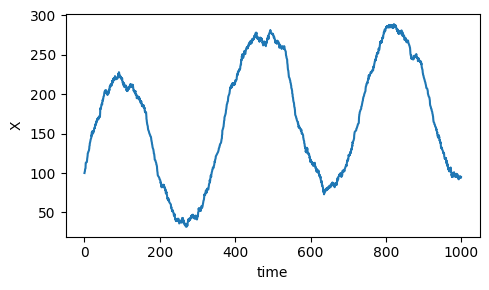

In [2]:
from src.Models.paper_examples import BirthDeathPaper
model_BD = BirthDeathPaper()
simulator_BD = SSASimulator(model_BD)

parameters_BD = model_BD.getDefaultParameter()
y, t = simulator_BD.run_ssa(np.array([100]), 1000, parameters_BD)

plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_BD)

In [3]:
scaler = StandardScaler()
y = scaler.fit_transform(y)

data = pd.DataFrame(data={'t': t, "y": y.reshape(-1)})

data['t_sin'] = np.sin(2 * np.pi * data.t)
data['t_cos'] = np.cos(2 * np.pi * data.t)
data = data.drop(columns=["t"])
data = data[["t_sin", 't_cos', "y"]]


train_data, test_data = train_test_split(data,test_size=0.5, shuffle=False)

generator = Generator(input_width=3, label_width=1, train_df=train_data, test_df=test_data)
model = MultiRNNTrainer([generator.train_generator()])
model.compile_and_fit(epochs=10)

[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>]
Epoch 1/10


2023-09-22 19:12:22.870607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-09-22 19:12:22.870647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: markphillip
2023-09-22 19:12:22.870651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: markphillip
2023-09-22 19:12:22.870764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-09-22 19:12:22.870786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  535.54.03  Release Build  (dvs-builder@U16-I2-C03-15-1)  Tue Jun  6 22:31:30 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


41/41 [==============================] - 1s 2ms/step - loss: 0.7759
Epoch 2/10
41/41 [==============================] - 0s 2ms/step - loss: 0.4284
Epoch 3/10
41/41 [==============================] - 0s 3ms/step - loss: 0.0977
Epoch 4/10
41/41 [==============================] - 0s 2ms/step - loss: 0.0879
Epoch 5/10
41/41 [==============================] - 0s 2ms/step - loss: 0.0770
Epoch 6/10
41/41 [==============================] - 0s 2ms/step - loss: 0.0730
Epoch 7/10
41/41 [==============================] - 0s 3ms/step - loss: 0.0702
Epoch 8/10
41/41 [==============================] - 0s 2ms/step - loss: 0.0677
Epoch 9/10
41/41 [==============================] - 0s 2ms/step - loss: 0.0654
Epoch 10/10
41/41 [==============================] - 0s 3ms/step - loss: 0.0632


1/1 [==============================] - 0s 212ms/step


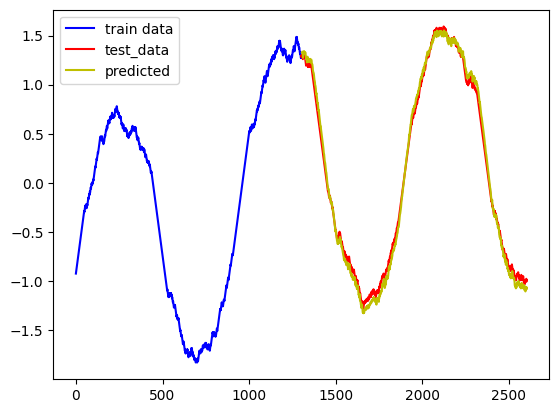

In [4]:
pred = []
targ = []
for feat, target in generator.test_generator():
    pred.append(np.array(model.models[0].predict(feat)))
    targ.append(np.array(target))
    
pred = np.vstack(pred)
targ = np.vstack(targ)

plt.plot(train_data.y, color='b', label="train data")
plt.plot(test_data.y, color='r', label="test_data")
plt.plot(test_data.index[3:],pred,color='y', label="predicted")
plt.legend()
plt.show()

In [5]:
from src.Models.paper_examples import ThreeSpeciesModel
model_LV = ThreeSpeciesModel()
simulator_LV = SSASimulator(model_LV)

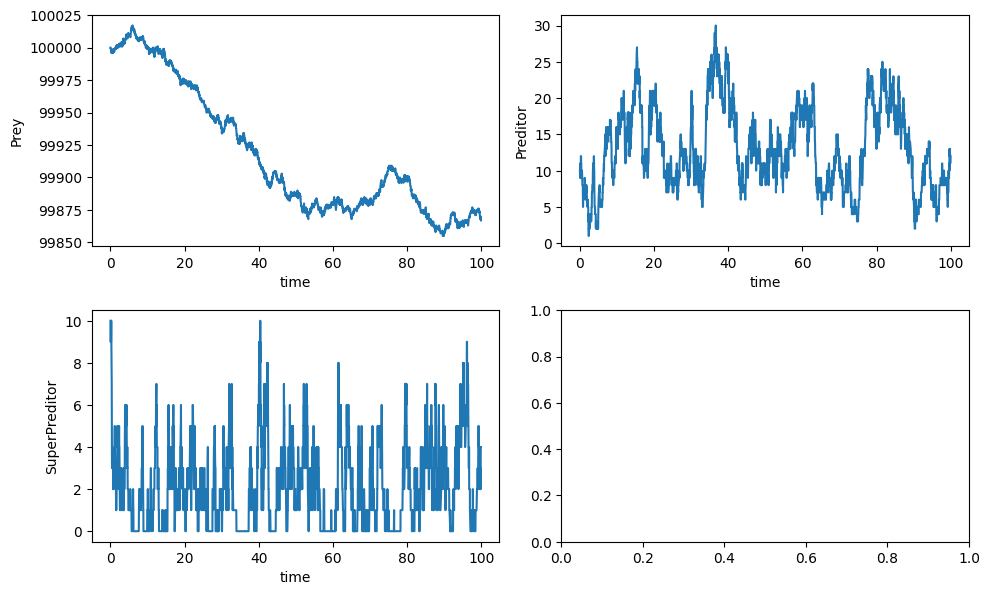

In [6]:
parameters_LV = model_LV.getDefaultParameter()

y, t = simulator_LV.run_ssa(np.array([10**5,10,10]), 100, parameters_LV)

plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_LV)

In [7]:
data = pd.DataFrame(data = {"t": t, "y_0": y[:,0], "y_1": y[:,1], "y_2": y[:,2]})
data[["y_0", "y_1", "y_2"]] = scaler.fit_transform(data[["y_0", "y_1", "y_2"]])
species_0 = data[["t", "y_0"]]
species_1 = data[["t", "y_1"]]
species_2 = data[["t", "y_2"]]


species_0_test = species_0.loc[0.5*len(species_0):]
species_1_test = species_1.loc[0.6*len(species_1):]
species_2_test = species_2.loc[0.7*len(species_2):]

species_0_test['t_sin'] = np.sin(2 * np.pi * species_0_test.t)
species_0_test['t_cos'] = np.cos(2 * np.pi * species_0_test.t)
species_0_test = species_0_test[["t_sin", 't_cos', "y_0"]]

species_1_test['t_sin'] = np.sin(2 * np.pi * species_1_test.t)
species_1_test['t_cos'] = np.cos(2 * np.pi * species_1_test.t)
species_1_test = species_1_test[["t_sin", 't_cos', "y_1"]]


species_2_test['t_sin'] = np.sin(2 * np.pi * species_2_test.t)
species_2_test['t_cos'] = np.cos(2 * np.pi * species_2_test.t)
species_2_test = species_2_test[["t_sin", 't_cos', "y_2"]]





species_0 = species_0.loc[:0.5*len(species_0)]
species_1 = species_1.loc[0.2*len(species_1):0.6*len(species_1)]
species_2 = species_2.loc[0.4*len(species_2):0.7*len(species_2)]


species_0['t_sin'] = np.sin(2 * np.pi * species_0.t)
species_0['t_cos'] = np.cos(2 * np.pi * species_0.t)
species_0 = species_0[["t_sin", 't_cos', "y_0"]]


species_1['t_sin'] = np.sin(2 * np.pi * species_1.t)
species_1['t_cos'] = np.cos(2 * np.pi * species_1.t)
species_1 = species_1[["t_sin", 't_cos', "y_1"]]


species_2['t_sin'] = np.sin(2 * np.pi * species_2.t)
species_2['t_cos'] = np.cos(2 * np.pi * species_2.t)
species_2 = species_2[["t_sin", 't_cos', "y_2"]]


/tmp/ipykernel_199685/3741018973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_0_test['t_sin'] = np.sin(2 * np.pi * species_0_test.t)
/tmp/ipykernel_199685/3741018973.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_0_test['t_cos'] = np.cos(2 * np.pi * species_0_test.t)
/tmp/ipykernel_199685/3741018973.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

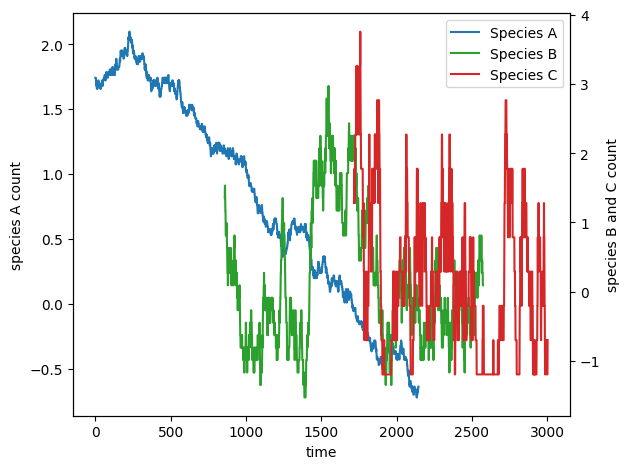

In [8]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('species A count')
ax1.plot(species_0.y_0, label="Species A", color = 'tab:blue')
# ax1.legend(loc="upper right")

ax2 = ax1.twinx()

ax2.set_ylabel("species B and C count")
ax2.plot(species_1.y_1, label="Species B", color = 'tab:green')

# ax3 = ax1.twinx()
ax2.plot(species_2.y_2, label="Species C", color = 'tab:red')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

In [9]:
generator_1 = Generator(input_width=6, label_width=1, train_df=species_0,test_df=species_0_test)
generator_2 = Generator(input_width=6, label_width=1, train_df=species_1,test_df=species_1_test)
generator_3 = Generator(input_width=6, label_width=1, train_df=species_2,test_df=species_2_test)


In [10]:
model  = MultiRNNTrainer([generator_1.train_generator(),
                          generator_2.train_generator(),
                          generator_3.train_generator()])
model.compile_and_fit(epochs=10)

[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>]
Epoch 1/10
67/67 [==============================] - 1s 3ms/step - loss: 0.6469
Epoch 2/10
67/67 [==============================] - 0s 3ms/step - loss: 0.1515
Epoch 3/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 4/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0442
Epoch 5/10
67/67 [==============================] - 0s 4ms/step - loss: 0.0866
Epoch 6/10
67/67 [==============================] - 0s 3ms/step - loss: 0.0817
Epoch 7/10
67/67 [==============================] - 0s

1/1 [==============================] - 0s 195ms/step


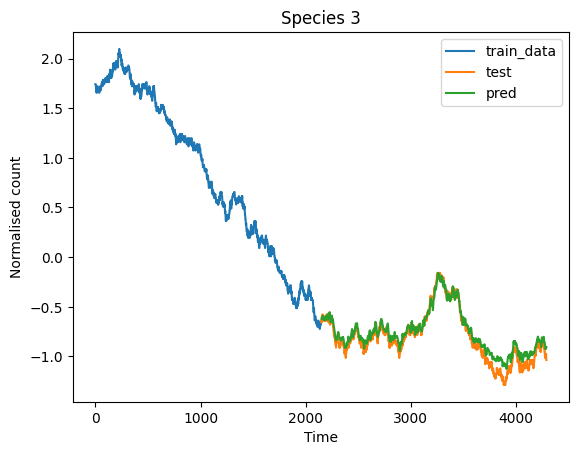

In [11]:
pred = []
targ = []
for feat, target in generator_1.test_generator():
    pred.append(np.array(model.models[0].predict(feat)))
    targ.append(np.array(target))
    
pred = np.vstack(pred)
targ = np.vstack(targ)

plt.plot(species_0["y_0"], label="train_data")
plt.plot(species_0_test.y_0, label="test")
plt.plot(species_0_test.index[6:], pred, label="pred")
plt.title("Species 3")
plt.xlabel("Time")
plt.ylabel("Normalised count")
plt.legend()
plt.show()
